# K-Means Clustering

In [2]:
%matplotlib inline

import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Clustering using K-Means") \
    .getOrCreate()

In [4]:
# load the dataset
data = spark.read.csv("data.csv", header=True, sep=',',inferSchema="true")
data = data.dropna()

## Feature selection
Eseguo il clustering utilizzando features che tra loro hanno una una correlazione inferiore ad una certa threshold, rimuoviamo da subito le features relative al tipo di match

In [5]:
categorical_columns = [ 'matchType', 'Id', 'groupId', 'matchId']
numerical_columns =[ 'assists',
                     'boosts',
                     'damageDealt',
                     #'DBNOs',
                     'headshotKills',
                     'heals',
                     'killPlace',
                     'killPoints',
                     'kills',
                     'killStreaks',
                     'longestKill',
                     'matchDuration',
                     #'maxPlace',
                     #'numGroups',
                     #'rankPoints',
                     #'revives',
                     'rideDistance',
                     'roadKills',
                     'swimDistance',
                     #'teamKills',
                     'vehicleDestroys',
                     'walkDistance',
                     'weaponsAcquired',
                     'winPoints',
                     'winPlacePerc']

In [6]:
# Assemblo le features numeriche
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numerical_columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

In [7]:
# Creo la correlation matrix
pearsonCorr = Correlation.corr(df_vector, vector_col, 'pearson').collect()[0][0]
corr_matrix = pd.DataFrame(pearsonCorr.toArray(), numerical_columns, numerical_columns)

In [8]:
corr_matrix

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.307683,0.406726,0.198289,0.228556,-0.290062,0.039066,0.319690,0.243471,0.261425,-0.019450,0.110644,0.011903,0.023372,0.057921,0.290305,0.243882,0.024014,0.299441
boosts,0.307683,1.000000,0.521947,0.334661,0.535854,-0.554844,0.008347,0.502024,0.405327,0.423290,0.072107,0.328855,0.035124,0.107993,0.087387,0.640150,0.406609,-0.007645,0.634234
damageDealt,0.406726,0.521947,1.000000,0.613409,0.342987,-0.677398,0.049904,0.888783,0.703599,0.563837,-0.006756,0.140883,0.052487,0.036729,0.081182,0.398199,0.353248,0.017762,0.440507
headshotKills,0.198289,0.334661,0.613409,1.000000,0.199917,-0.469829,0.023988,0.674275,0.512882,0.447261,-0.017657,0.076495,0.013369,0.028531,0.039200,0.250982,0.217552,0.004982,0.277722
heals,0.228556,0.535854,0.342987,0.199917,1.000000,-0.386032,-0.002585,0.311781,0.270412,0.263278,0.108901,0.297484,0.024619,0.079587,0.062870,0.430266,0.309071,-0.010990,0.427857
killPlace,-0.290062,-0.554844,-0.677398,-0.469829,-0.386032,1.000000,-0.023278,-0.730499,-0.810517,-0.541146,-0.005806,-0.236202,-0.057356,-0.089396,-0.073569,-0.590236,-0.490144,-0.002415,-0.719069
killPoints,0.039066,0.008347,0.049904,0.023988,-0.002585,-0.023278,1.000000,0.036192,0.037091,0.014084,-0.099542,-0.029316,-0.004156,-0.004604,-0.009658,0.004630,-0.003978,0.983417,0.012908
kills,0.319690,0.502024,0.888783,0.674275,0.311781,-0.730499,0.036192,1.000000,0.802500,0.602936,-0.030688,0.114750,0.063651,0.039127,0.079991,0.374774,0.336414,0.006929,0.419916
killStreaks,0.243471,0.405327,0.703599,0.512882,0.270412,-0.810517,0.037091,0.802500,1.000000,0.515097,-0.034645,0.098420,0.065575,0.034588,0.064374,0.327639,0.275373,0.008552,0.377566
longestKill,0.261425,0.423290,0.563837,0.447261,0.263278,-0.541146,0.014084,0.602936,0.515097,1.000000,0.056613,0.190853,0.025214,0.053455,0.083227,0.413810,0.276264,-0.003720,0.410154


In [9]:
kmeans_feats = [ 'assists',
                 'headshotKills',
                 'heals',
                 'kills',
                 'killStreaks',
                 'longestKill',
                 'rideDistance',
                 'roadKills',
                 'swimDistance',
                 'vehicleDestroys',
                 'walkDistance']

## K-Means: Ottimizzazione del miglior K
Eseguo k-means provando un range di K. Test eseguito su un sample del 1% del dataset

In [10]:
# Assemblo le features meno correlate
assemble = VectorAssembler(inputCols=kmeans_feats, outputCol='features')
ass_data = assemble.transform(data)

In [11]:
ass_data.select('features').show(5,False)

+-------------------------------------+
|features                             |
+-------------------------------------+
|(11,[10],[244.8])                    |
|(11,[6,8,10],[0.0045,11.04,1434.0])  |
|(11,[0,10],[1.0,161.8])              |
|(11,[10],[202.7])                    |
|(11,[3,4,5,10],[1.0,1.0,58.53,49.75])|
+-------------------------------------+
only showing top 5 rows



In [12]:
# Normalizzo
mms = MinMaxScaler(inputCol='features',outputCol="scaled")
scaler_model = mms.fit(ass_data)
scaled_data = scaler_model.transform(ass_data)

In [13]:
scaled_data.select("scaled").show(5)

+--------------------+
|              scaled|
+--------------------+
|(11,[10],[0.00949...|
|(11,[6,8,10],[1.1...|
|(11,[0,10],[0.045...|
|(11,[10],[0.00786...|
|(11,[3,4,5,10],[0...|
+--------------------+
only showing top 5 rows



In [10]:
%%time
# Eseguo il clustering su un range di k: calcolo sse e silhouette
n = 15
sse = np.zeros(n+1)
silhouette = np.zeros(n+1)

for k in range(2,n+1):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('scaled').setPredictionCol('cluster')
    evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaled',
                                        metricName='silhouette',distanceMeasure='squaredEuclidean')
    model = kmeans.fit(scaled_data.sample(withReplacement=False, fraction=0.2, seed=42))
    predictions = model.transform(scaled_data)

    sse[k] = model.summary.trainingCost
    silhouette[k] = evaluator.evaluate(predictions)
    
    print(f"K={k}, SSE={sse[k]}, Silhouette:{silhouette[k]}")

K=2, SSE=6018.752890496059, Silhouette:0.5870680104755717
K=3, SSE=5064.1354177325575, Silhouette:0.5037822798312688
K=4, SSE=4501.203929616424, Silhouette:0.5035591091504034
K=5, SSE=4042.688078551127, Silhouette:0.4905279233058109
K=6, SSE=3599.4311616512473, Silhouette:0.44847964602852863
K=7, SSE=3337.394804355577, Silhouette:0.46738425076311874
K=8, SSE=3172.856519875785, Silhouette:0.481501787740171
K=9, SSE=3090.9012379273054, Silhouette:0.47752698432155444
K=10, SSE=3011.6131157963905, Silhouette:0.4795548246970268
K=11, SSE=2867.0196628060976, Silhouette:0.46790714102655695
K=12, SSE=2773.5958456426797, Silhouette:0.47150026725954225
K=13, SSE=2565.6061694304476, Silhouette:0.501812616308118
K=14, SSE=2521.5348474357243, Silhouette:0.46464044058891363
K=15, SSE=2390.3147181586532, Silhouette:0.48548823481683223
CPU times: user 398 ms, sys: 110 ms, total: 508 ms
Wall time: 54min 12s


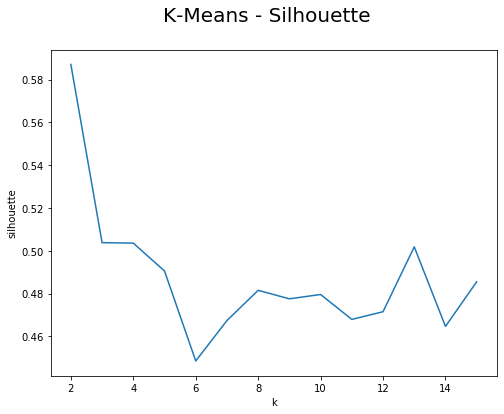

In [11]:
# silhouette
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n+1),silhouette[2:n+1])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')
fig.suptitle('K-Means - Silhouette', fontsize=20)
#plt.savefig('kmeans_silhouette.pdf', bbox_inches='tight')

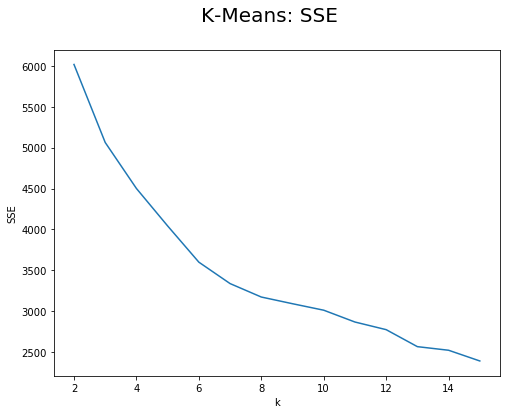

In [12]:
# sse
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n+1),sse[2:n+1])
ax.set_xlabel('k')
ax.set_ylabel('SSE')
fig.suptitle('K-Means: SSE', fontsize=20)
#plt.savefig('kmeans_sse.pdf', bbox_inches='tight')

## K-Means with best K=5 on Entire Dataset

In [14]:
# Eseguo il clustering col miglior k sull'intero dataset
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol('scaled').setPredictionCol('cluster')
evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaled',
                                    metricName='silhouette',distanceMeasure='squaredEuclidean')
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

In [16]:
# Info sse, silhouette, cluster_sizes, centers
sse = model.summary.trainingCost
silhouette = evaluator.evaluate(predictions)
cluster_sizes = model.summary.clusterSizes
centers = model.clusterCenters()

print(f"K-Means k=5 results:\nSSE: {sse}\Silhouette: {silhouette}\nCluster sizes: {cluster_sizes}\nCentroids:\n {centers}")

K-Means k=5 results:
SSE: 20241.51263461442\Silhouette: 0.48824119699302215
Cluster sizes: [2458597, 627965, 247826, 297103, 815474]
Centroids:
 [array([3.89141457e-03, 9.56852090e-04, 3.67519154e-03, 3.76454321e-03,
       1.13427739e-02, 2.93466670e-03, 2.20128224e-03, 4.43315414e-05,
       2.37991402e-04, 2.64281060e-04, 1.29831725e-02]), array([1.17889554e-02, 9.11572343e-04, 2.42888579e-02, 4.15717400e-03,
       1.21744133e-02, 4.02000725e-03, 1.29411280e-02, 6.00326684e-05,
       3.26543922e-03, 1.30274422e-03, 1.00190549e-01]), array([0.03723255, 0.01694906, 0.04730647, 0.05289968, 0.07189286,
       0.17430461, 0.03891129, 0.00052409, 0.00267175, 0.00757387,
       0.10987672]), array([0.015343  , 0.00314616, 0.04975663, 0.01255523, 0.02872387,
       0.01820688, 0.12234997, 0.00132922, 0.00215408, 0.00750754,
       0.07726101]), array([0.02031124, 0.00948047, 0.03118128, 0.0349481 , 0.07252403,
       0.04357453, 0.00831219, 0.00023729, 0.00160451, 0.00182036,
       0.066

In [18]:
#inverse_transfrom
X_original = centers * (scaler_model.originalMax.toArray() - scaler_model.originalMin.toArray()) + scaler_model.originalMin.toArray()

In [20]:
centers_df = pd.DataFrame(X_original, columns=kmeans_feats)
centers_df

,assists,headshotKills,heals,kills,killStreaks,longestKill,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance
0,0.086,0.061,0.294,0.271,0.227,3.211,89.614,0.001,0.910,0.001,334.706
1,0.259,0.058,1.943,0.299,0.243,4.398,526.833,0.001,12.484,0.007,2582.912
2,0.819,1.085,3.785,3.809,1.438,190.689,1584.079,0.009,10.214,0.038,2832.622
3,0.338,0.201,3.981,0.904,0.574,19.918,4980.867,0.024,8.235,0.038,1991.789
4,0.447,0.607,2.495,2.516,1.450,47.671,338.389,0.004,6.134,0.009,1712.127


In [21]:
centers_df_scaled = pd.DataFrame(centers, columns=kmeans_feats)

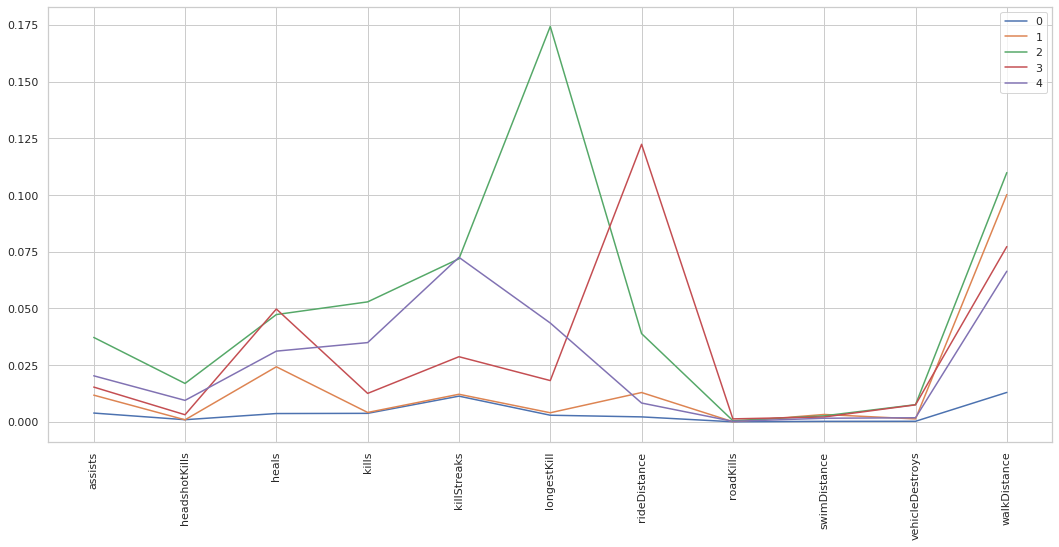

In [22]:
#parallel coordinates of cluster centers
sns.set_theme(style="whitegrid")
ax = centers_df_scaled.T.plot(figsize=(18, 8))
ax.set_xticks(range(len(kmeans_feats)))
ax.set_xticklabels(kmeans_feats, rotation=90)
plt.savefig('cluster_centers2.pdf', bbox_inches='tight')
plt.show()

## Plots

In [23]:
from pyspark.sql import SQLContext

sqlCtx = SQLContext(spark)

In [24]:
from pyspark.sql.functions import col
#discretizzazione matchType
toKeep = ['duo', 'solo', 'squad', 'duo-fpp', 'squad-fpp', 'solo-fpp']
predictions = predictions.filter(predictions.matchType.isin(toKeep))

predictions = predictions.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

In [25]:
#discretizzazione winPlacePerc
predictions = predictions.withColumn('winPlaceClass', when(col("winPlacePerc") == 0, 6)
                                .when(col("winPlacePerc") == 1,  1)
                                .when( (col("winPlacePerc") > 0) & (col("winPlacePerc") <= 0.25 ), 5)
                                .when( (col("winPlacePerc") > 0.25) & (col("winPlacePerc") <= 0.5 ), 4)
                                .when( (col("winPlacePerc") > 0.5) & (col("winPlacePerc") <= 0.75 ), 3)
                                .when( (col("winPlacePerc") > 0.75) & (col("winPlacePerc") < 1 ), 2)
               )

In [47]:
predictions.createOrReplaceTempView("pubg")

In [89]:
#analizziamo le distribuzioni di winPlacePerc e matchType nei cluster
cols = kmeans_feats + ['cluster', 'winPlacePerc', 'winPlaceClass', 'matchType']
sample_df = predictions.select(cols).sample(withReplacement=False, fraction=0.001, seed=42).toPandas()
sample_df.head()

,assists,headshotKills,heals,kills,killStreaks,longestKill,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,cluster,winPlacePerc,winPlaceClass,matchType
0,0,0,0,0,0,0.000,0.000,0,0.000,0,0.000,0,0.000,6,1
1,1,1,1,1,1,17.470,0.000,0,0.000,0,318.900,0,0.143,5,2
2,0,0,0,0,0,0.000,0.000,0,0.000,0,1070.000,0,0.489,4,2
3,0,0,0,0,0,0.000,0.000,0,0.000,0,261.200,0,0.267,4,2
4,0,0,0,0,0,0.000,0.000,0,0.000,0,96.780,0,0.250,5,4


In [90]:
# Normalizzo il dataframe sample
from sklearn.preprocessing import MinMaxScaler

sample_df[kmeans_feats] = MinMaxScaler().fit_transform(sample_df.loc[:, ~sample_df.columns.isin(['cluster', 'matchType','winPlaceClass', 'winPlacePerc'])])
sample_df.head()

,assists,headshotKills,heals,kills,killStreaks,longestKill,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,cluster,winPlacePerc,winPlaceClass,matchType
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,6,1
1,0.167,0.111,0.028,0.059,0.200,0.020,0.000,0.000,0.000,0.000,0.049,0,0.143,5,2
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.166,0,0.489,4,2
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0,0.267,4,2
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.015,0,0.250,5,4


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


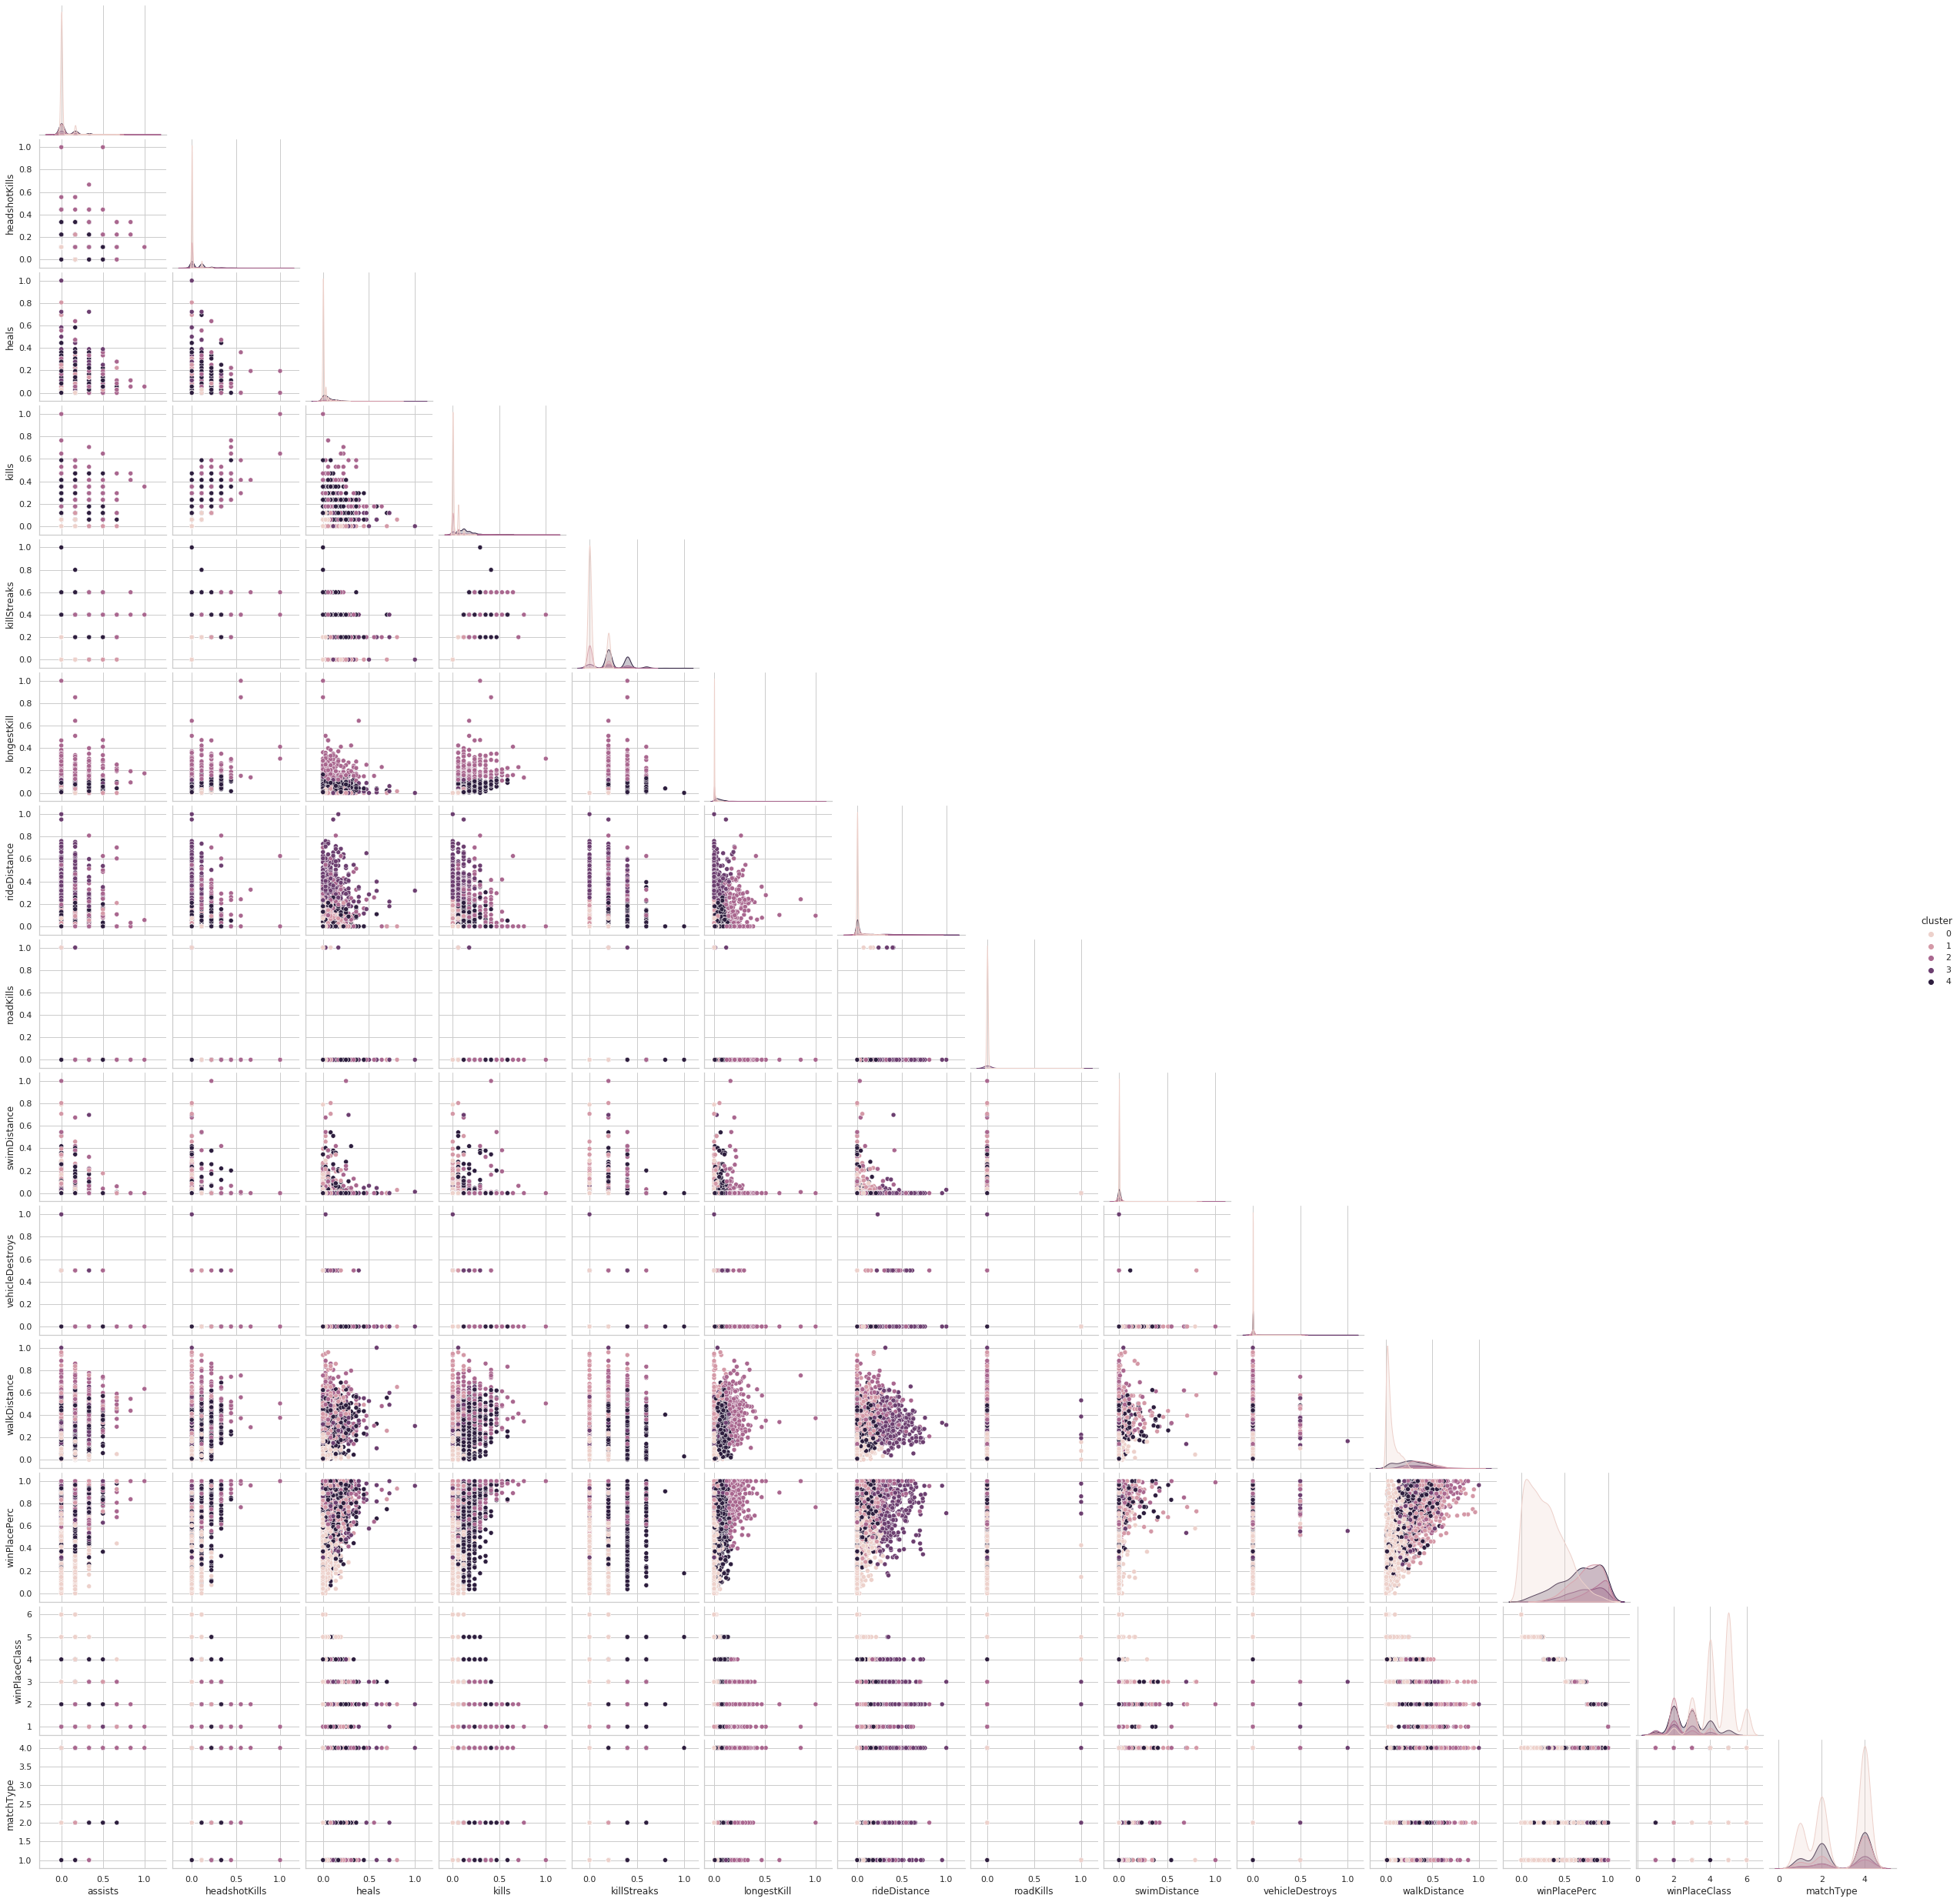

In [43]:
sns.pairplot(sample_df,hue = "cluster",corner=True)

In [48]:
winPlaceClass = sqlCtx.sql("""SELECT winPlaceClass, COUNT(*) as count FROM pubg GROUP BY winPlaceClass""")
winPlaceClass.show()

+-------------+-------+
|winPlaceClass|  count|
+-------------+-------+
|            1| 124921|
|            6| 217551|
|            3| 952096|
|            5|1126345|
|            4|1058114|
|            2| 932671|
+-------------+-------+



In [49]:
total = sqlCtx.sql("""SELECT COUNT(*) as total FROM pubg""")
total.show()

+-------+
|  total|
+-------+
|4411698|
+-------+



In [50]:
winPlaceClassDF = winPlaceClass.toPandas().set_index('winPlaceClass') / total.toPandas().iloc[0,0]
winPlaceClassDF

,count
winPlaceClass,
1,0.028
6,0.049
3,0.216
5,0.255
4,0.240
2,0.211


In [51]:
cluster_matchType = sqlCtx.sql("""SELECT cluster, matchtype, COUNT(*) as count FROM pubg GROUP BY cluster, matchtype""")
cluster_count = sqlCtx.sql("""SELECT cluster, COUNT(*) as count FROM pubg GROUP BY cluster""")
cluster_matchType.show()

+-------+---------+-------+
|cluster|matchtype|  count|
+-------+---------+-------+
|      3|        1|  35465|
|      2|        2|  68869|
|      1|        2| 164898|
|      1|        1|  75724|
|      1|        4| 383272|
|      2|        1|  31620|
|      2|        4| 142772|
|      0|        1| 450608|
|      3|        2|  84466|
|      0|        2| 733382|
|      3|        4| 168850|
|      4|        2| 258667|
|      4|        4| 423424|
|      4|        1| 125287|
|      0|        4|1264394|
+-------+---------+-------+



In [104]:
cluster_count.withColumn('perc', col('count') / 4411698).show()

+-------+-------+-------------------+
|cluster|  count|               perc|
+-------+-------+-------------------+
|      1| 623894|0.14141811157518036|
|      3| 288781|0.06545801639187451|
|      4| 807378|0.18300844708771996|
|      2| 243261|  0.055139993716705|
|      0|2448384| 0.5549754312285202|
+-------+-------+-------------------+



In [52]:
cluster_matchTypeDF = cluster_matchType.toPandas().set_index(['cluster','matchtype'])
cluster_countDF = cluster_count.toPandas().set_index('cluster')

In [53]:
cluster_matchTypePerc = (cluster_matchTypeDF/cluster_countDF).reset_index()

In [54]:
matchtype_pivot_df = cluster_matchTypePerc.pivot(index='cluster', columns='matchtype', values='count')
matchtype_pivot_df

matchtype,1,2,4
cluster,,,
0,0.184,0.300,0.516
1,0.121,0.264,0.614
2,0.130,0.283,0.587
3,0.123,0.292,0.585
4,0.155,0.320,0.524


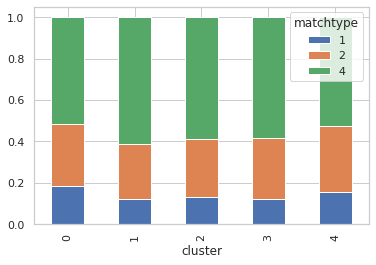

In [55]:
matchtype_pivot_df.plot.bar(stacked=True)
#plt.savefig('matchtype_cluster.pdf', bbox_inches='tight')
plt.show()

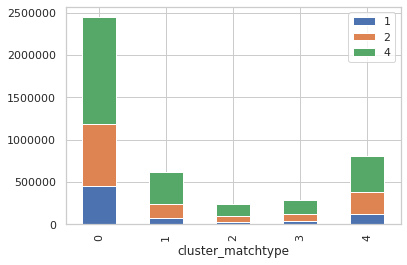

In [56]:
cross_tab = predictions.crosstab('cluster', 'matchtype').toPandas().sort_values(by=["cluster_matchtype"]).set_index('cluster_matchtype')
cross_tab.plot.bar(stacked=True)

In [57]:
cluster_winPlaceClass = sqlCtx.sql("""SELECT cluster, winPlaceClass, COUNT(*) as count FROM pubg GROUP BY cluster, winPlaceClass""")
cluster_winPlaceClass.show()

+-------+-------------+-------+
|cluster|winPlaceClass|  count|
+-------+-------------+-------+
|      3|            1|  13172|
|      2|            2| 144642|
|      2|            3|  42079|
|      1|            2| 305432|
|      0|            5|1072976|
|      1|            1|  19894|
|      1|            3| 245651|
|      3|            5|   1533|
|      2|            5|    615|
|      1|            4|  51026|
|      3|            3| 111068|
|      4|            3| 266519|
|      2|            1|  48070|
|      2|            4|   7849|
|      4|            6|   1243|
|      3|            6|     52|
|      0|            1|   4084|
|      3|            2| 129816|
|      1|            5|   1882|
|      0|            6| 216241|
+-------+-------------+-------+
only showing top 20 rows



In [58]:
cluster_winPlaceClassDF = cluster_winPlaceClass.toPandas().set_index(['cluster','winPlaceClass'])

In [59]:
cluster_winPlaceClassPerc = (cluster_winPlaceClassDF/cluster_countDF).reset_index()

In [60]:
winPlaceClass_pivot_df = cluster_winPlaceClassPerc.pivot(index='cluster', columns='winPlaceClass', values='count')
winPlaceClass_pivot_df

winPlaceClass,1,2,3,4,5,6
cluster,,,,,,
0,0.002,0.023,0.117,0.332,0.438,0.088
1,0.032,0.490,0.394,0.082,0.003,0.000
2,0.198,0.595,0.173,0.032,0.003,0.000
3,0.046,0.450,0.385,0.115,0.005,0.000
4,0.049,0.367,0.330,0.191,0.061,0.002


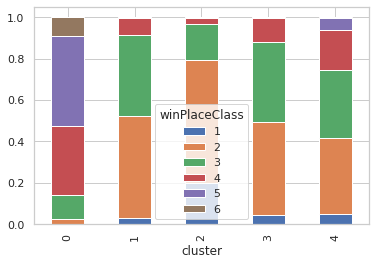

In [61]:
winPlaceClass_pivot_df.plot.bar(stacked=True)
#plt.savefig('winPlaceClass_cluster.pdf', bbox_inches='tight')
plt.show()

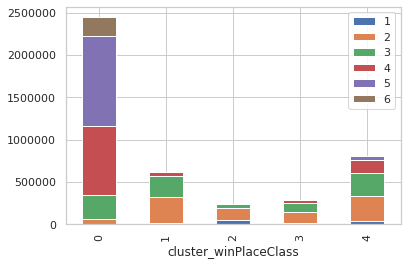

In [62]:
cross_tab = predictions.crosstab('cluster', 'winPlaceClass').toPandas().sort_values(by=["cluster_winPlaceClass"]).set_index('cluster_winPlaceClass')
cross_tab.plot.bar(stacked=True)

<Figure size 432x288 with 0 Axes>

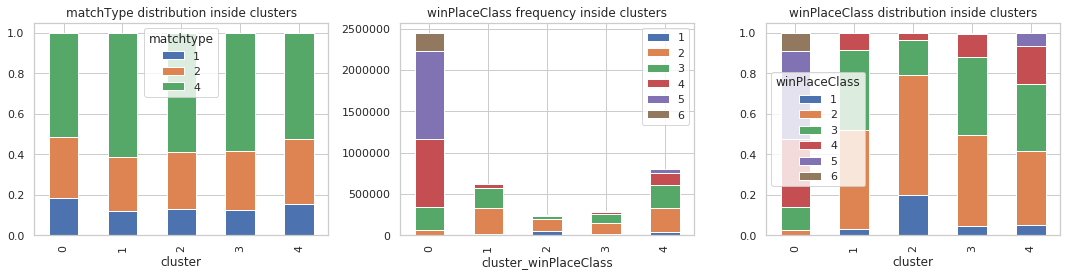

In [63]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

matchtype_pivot_df.plot.bar(stacked=True, ax=axes[0], title="matchType distribution inside clusters")
cross_tab.plot.bar(stacked=True, ax=axes[1], title='winPlaceClass frequency inside clusters')
winPlaceClass_pivot_df.plot.bar(stacked=True, ax=axes[2], title='winPlaceClass distribution inside clusters')

fig.tight_layout()
fig.savefig('cluster_matchtype_class2.pdf', bbox_inches='tight')
plt.show()

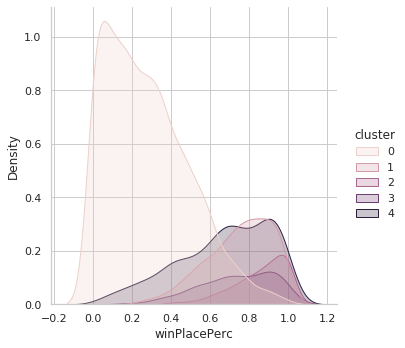

In [91]:
sns.displot(sample_df, x="winPlacePerc", hue="cluster", kind="kde", fill=True)

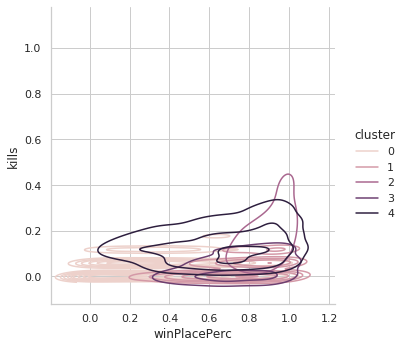

In [96]:
sns.displot(sample_df, x="winPlacePerc", y="kills", hue="cluster", kind="kde")

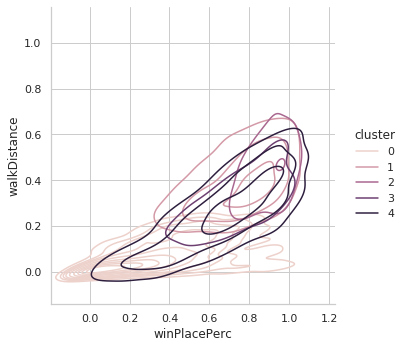

In [97]:
sns.displot(sample_df, x="winPlacePerc", y="walkDistance", hue="cluster", kind="kde")

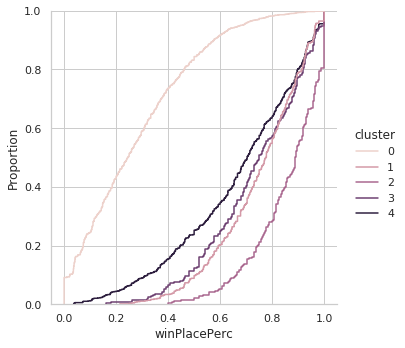

In [101]:
sns.displot(sample_df, x="winPlacePerc", hue="cluster", kind="ecdf")

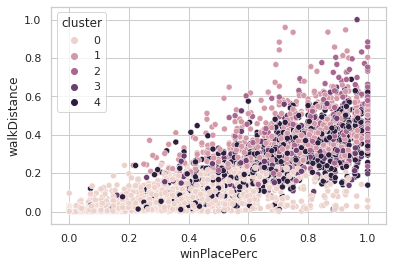

In [64]:
sns.scatterplot(data=sample_df, x="winPlacePerc", y="walkDistance", hue="cluster")
fig.savefig('maxPlace_matchDuration.pdf', bbox_inches='tight')
plt.show()

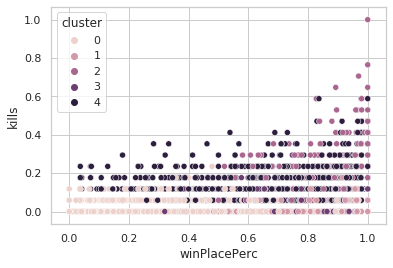

In [65]:
sns.scatterplot(data=sample_df, x="winPlacePerc", y="kills", hue="cluster")

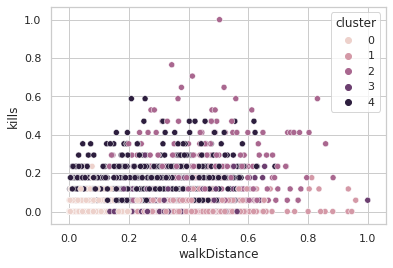

In [66]:
sns.scatterplot(data=sample_df, x="walkDistance", y="kills", hue="cluster")

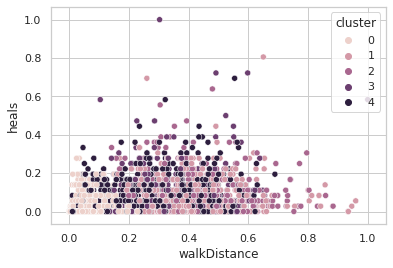

In [69]:
sns.scatterplot(data=sample_df, x="walkDistance", y="heals", hue="cluster")

In [70]:
def plot3d(df,x,y,z):
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(df[x], df[y], df[z], c=df.cluster)
    threedee.set_xlabel(x)
    threedee.set_ylabel(y)
    threedee.set_zlabel(z)
    plt.show()

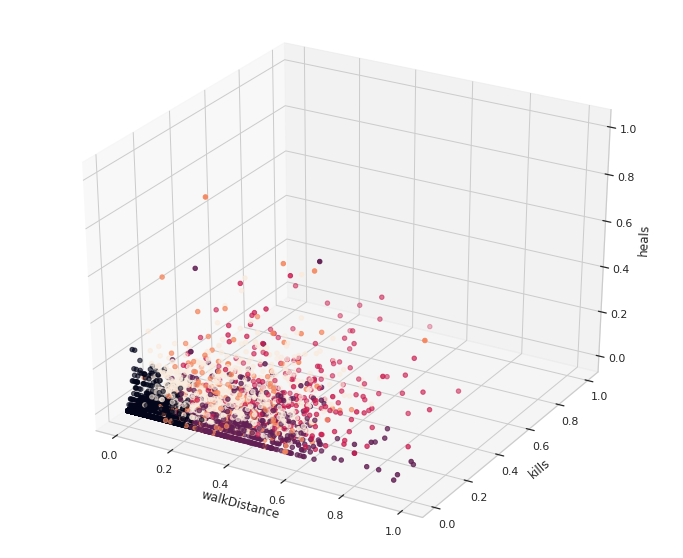

In [73]:
plot3d(sample_df,'walkDistance','kills','heals')

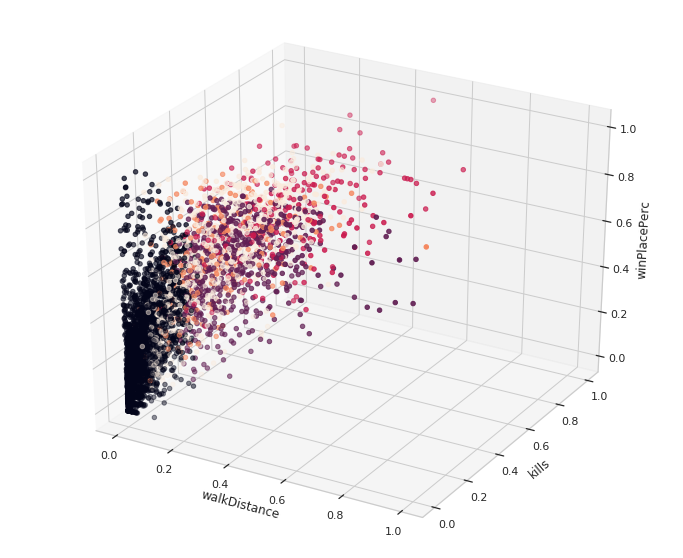

In [74]:
plot3d(sample_df,'walkDistance','kills','winPlacePerc')

In [86]:
cl = sample_df['cluster']
sample_df = sample_df.drop(inplace=False, columns=['cluster', 'matchType','winPlaceClass', 'winPlacePerc'])

In [87]:
from sklearn.decomposition import PCA

pca = PCA(3, random_state=42)
pca.fit(sample_df)
pca_proj = pca.transform(sample_df)
df_pca = pd.DataFrame(pca_proj[:,:3], columns= ['pca1', 'pca2', 'pca3'])
df_pca

,pca1,pca2,pca3
0,-0.231,0.010,0.004
1,-0.025,0.164,0.017
2,-0.109,-0.077,-0.056
3,-0.201,-0.011,-0.011
4,-0.220,0.002,-0.002
...,...,...,...
4552,-0.101,0.143,0.122
4553,0.489,0.088,-0.133
4554,-0.027,0.133,-0.001
4555,-0.198,-0.013,-0.012


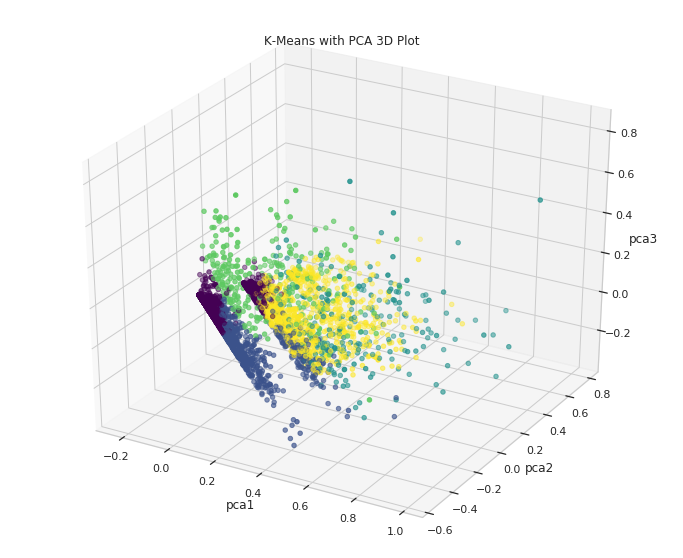

In [88]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')

x = df_pca['pca1']
y = df_pca['pca2']
z = df_pca['pca3']
c = cl

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

scatter = ax.scatter(x, y, z, c=c, cmap='viridis')
ax.set_title('K-Means with PCA 3D Plot')

plt.show()